Handwritten digit recognition using a Gaussian generative model. In class, we mentioned the MNIST data set of handwritten digits. You can obtain it from: 
                          http://yann.lecun.com/exdb/mnist/index.html

In this problem, you will build a classifier for this data, by modeling each class as a multivariate (784-dimensional) Gaussian.

Each example in the mnist dataset is a 28x28 pixel image:

In [1]:
import math
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
28*28

784

In [3]:
math.sqrt(784)

28.0

We have 10 classes to classify: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. Each class is modeled by a multivariate 784-dimensional gaussian. In other words we have a 784-dimensional feature vector and 10 768 degree multivariate gaussians.

# Iris

On a smaller scale we can do this w/ the iris dataset. 4 Features/target. 4 classes. So each class would have a 4D M-Gaussian. This is actually a really good model for IRIS b/c gaussians follow the random patterns in nature and iris is samples from nature.

In [4]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(iris.data, iris.target)

GaussianNB()

As you can see from the Iris data, we have 150 examples, with 3 total classes. Therefore the class priori or $π_j = 1/3$

In [5]:
print gnb.classes_
print gnb.class_count_
print gnb.class_prior_
print gnb.sigma_ # variance of each feature per class -- not Sigma in the context of covariance matrix

[0 1 2]
[ 50.  50.  50.]
[ 0.33333333  0.33333333  0.33333333]
[[ 0.121764  0.142276  0.029504  0.011264]
 [ 0.261104  0.0965    0.2164    0.038324]
 [ 0.396256  0.101924  0.298496  0.073924]]


Now, what scikit did was to fit a gaussian to each of the classes (3) in the training set examples. It does that by finding the mean and the covariance from the examples. Let the Gaussian for the jth class be: $P_j = N(\mu_j, \Sigma_j)$.

$\DeclareMathOperator*{\argmax}{arg\,max}$
Then in order to classify an unknown flower, simply use the class prior w/ the class posterior (bayes rule) fo all the classes and choose the one w/ the largest probability:

$$\argmax \pi_j*P_j$$

In [6]:
y_pred = gnb.predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d" % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


Easy huh? Now, the devil is in the details: how do you calculate $P_j$, how do we estimate a gaussian for each class j?

$$P_j = N(\mu_j, \Sigma_j)$$

We know that $N(\mu_j, \Sigma_j)$, the probability density function (PDF) of a multivariate Gaussian is this standard form:

$$
P(\hat{X}) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$


Therefore the trick is to tune $\Sigma$, the covariance matrix, to model the trainitg data.

$\Sigma$ is a p x p matrix containing all pairwise covariances, where p is the number of features in your training set:

$$
\Sigma_{ij} = \Sigma_{ji} = cov(X_i, X_j)    if i!=j
$$
$$
\Sigma_{ii} = var(X_i)
$$


$$
\begin{bmatrix}
    var(x_1) & cov(x_1,x_2) & \dots  & x_{1n} \\
    cov(x_2) & var(x_2) & \dots  & x_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{d1} & x_{d2} & \dots  & var(x_n)
\end{bmatrix}
$$

Then, given some training points, the way to generate this matrix is marked w/ a start on my notes:

for each target/class (10) you will get a $\mu$ and a $\Sigma$ that you can pop into the numpy PDF routine: `np.random.multivariate_normal`

In [7]:
#numpy np.random.multivariate_normal routine exmaple
mean = [0, 0]
cov = [[9, 0], [0, 1]]  
x,y = np.random.multivariate_normal(mean, cov, 100).T

For mnist dataset we will have 4x4 covariance matrix b/c there are 4 features in our training set., here's an example of finding the covariance matrix $\Sigma$ on the iris trainging set. We should be abel to confirm our answer

In [8]:
#lets split into a test and training set
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(iris.data,iris.target, test_size=0.4, random_state=4)

# lets gather all the examples from class 0
def get_examples_for_class(class_id):
    examples = []
    for i, example in enumerate(X_train):
        if Y_train[i]==class_id:
            examples.append(example)
        
    examples = np.matrix(examples)
    return examples

examples = get_examples_for_class(0)
examples.shape

(25, 4)

Now according to the above assertion this should map to a 4x4 covariance matrix. We can use `numpy.cov` to test this assertion and then look at how to implement the equivilent `numpy.cov` in python.

In [9]:
mean = np.array(examples.mean(0))[0]
cov = np.cov(examples.T) # I don't know why you have to transpose the input to numpy... 
print mean
print cov #should be 4x4 for iris

[ 4.964  3.416  1.44   0.24 ]
[[ 0.1049      0.06976667  0.01483333  0.00566667]
 [ 0.06976667  0.10723333  0.00391667  0.00266667]
 [ 0.01483333  0.00391667  0.02583333  0.00625   ]
 [ 0.00566667  0.00266667  0.00625     0.01      ]]


Now we can take this covariance matrix and pipe it into the numpy PDF routine to get our distribution:

In [10]:
from scipy.stats import multivariate_normal

In [11]:
P_0 = np.random.multivariate_normal(mean, cov).T
P_0

var = multivariate_normal(mean=mean, cov=cov)

Now according to equation 1, if we want to classify some vector, X,

$$\argmax_j \pi_j*P_j(X)$$

lets test the probabity the the following test vector is in class 0, or:

$$ \pi_0*P_0(X) $$

where, X is the vector below:

In [12]:
X1=X_test[15]
import random
X1 = random.choice (X_test)
print X1

[ 5.7  4.4  1.5  0.4]


In [13]:
prior = pi_0 = gnb.class_prior_[0]
prob_0=[0, var.pdf(X1)]
prob_0

[0, 0.08678207121797761]

$P_1 = N(\mu_1, \Sigma_1)$

In [14]:
#now for class 1
examples_1 = get_examples_for_class(1)
mean_1 = np.array(examples_1.mean(0))[0]
cov_1 = np.cov(examples_1.T)
p_x_1 = multivariate_normal(mean=mean_1, cov=cov_1)
prob_1 = [1, gnb.class_prior_[1] * p_x_1.pdf(X1)]
prob_1

[1, 3.0864750077334886e-44]

In [15]:
#now for class 2
examples_2 = get_examples_for_class(2)
mean_2 = np.array(examples_2.mean(0))[0]
cov_2 = np.cov(examples_2.T)
p_x_2 = multivariate_normal(mean=mean_2, cov=cov_2)
prob_2 = [2, gnb.class_prior_[2] * p_x_2.pdf(X1)]
prob_2

[2, 3.4459557583437947e-66]

In [16]:
prediction = max(prob_0, prob_1, prob_2, key= lambda a: a[1])
print iris.target_names[prediction[0]]

setosa


In [17]:
X = iris.data
Y = iris.target
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)

print(iris.target_names[clf.predict([X1])][0])



setosa


So it seems to be a functioning classifier. Now lets scale this up and test it on the digits dataset.

## Digits

Digits should have 10 classes: 0-9 with each example having 784 (representing 28x28 pixel image). A note: scikit's version of nmist is only 8x8 whereas the original is 28*28. SO as you can see above we have 64 features instead of 784

In [18]:
digits = datasets.load_digits()
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size=0.4, random_state=4)
X_train.shape

(1078, 64)

First we need to calculate the prior probabilites of the 10 classes. For the sake of lazyness well just use NBClassifer to gen these values for us:

In [19]:
helper = GaussianNB()
helper.fit(X_train, Y_train)
classes = helper.classes_
priors = helper.class_prior_
priors

array([ 0.09369202,  0.10482375,  0.0974026 ,  0.0974026 ,  0.10575139,
        0.10296846,  0.0974026 ,  0.10018553,  0.09925788,  0.10111317])

So from the above we can see the baysian prior probabilities for the 10 classes 0-9 whick looks like a pretty even distribution.

## Training

Now lets generate the baysian posteror probabilities for each class using the training data.

See this note on the covariance matrix tuning: http://stackoverflow.com/questions/35273908/scipy-stats-multivariate-normal-raising-linalgerror-singular-matrix-even-thou/35293215

In [20]:
posteriors=[]

for klass in classes:
    examples = get_examples_for_class(klass)
    mean = np.array(examples.mean(0))[0]
    cov = np.cov(examples.T)
    p_x = multivariate_normal(mean=mean, cov=cov, allow_singular=True)
    posteriors.append(p_x)

## Classification

Now that we have the prior and posterior probabilities for our training set, lets use that to make a prediction:

In [21]:
#choose a random point from the test data
x = random.choice (X_test)
print x

[  0.   0.   0.   0.   6.  15.   2.   0.   0.   0.   0.   5.  16.  16.   2.
   0.   0.   0.   4.  16.  12.  16.   0.   0.   0.   4.  15.   6.   7.  13.
   0.   0.   0.  11.  15.  15.  16.  16.   9.   0.   0.   9.  13.  12.  13.
  14.   3.   0.   0.   0.   0.   0.   9.   8.   0.   0.   0.   0.   0.   0.
   8.   8.   0.   0.]


In [22]:
bayes_probs = []
for klass in classes:
    prob = [klass, priors[klass] * posteriors[klass].pdf(x)]
    bayes_probs.append(prob)
bayes_probs

[[0, 0.0],
 [1, 5.8802340424920592e-222],
 [2, 0.0],
 [3, 0.0],
 [4, 9.9863047311482061e-62],
 [5, 0.0],
 [6, 0.0],
 [7, 0.0],
 [8, 0.0],
 [9, 0.0]]

Notice that the probabilities are VERY small. In this discrete environment we may be losing a lot of percission, so it may be wise to explore using the `log_pdf` instead. We will explore this more later.

Now we choose the max and that is our prediction:

In [23]:
prediction = max(bayes_probs, key= lambda a: a[1])
print digits.target_names[prediction[0]]

4


So our routine predicted a 4, lets visually confirm:

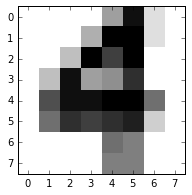

In [28]:
plt.figure(1, figsize=(3, 3))
plt.imshow(x.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Success!

## Benchmark

Now lets scale this up and check our error rate

In [49]:
#first I need an interface to batch test, test input (instead of 1 vector at a time, like above)

Y = []
for x in X_test:
    bayes_probs = []
    for klass in classes:
        prob = [klass, priors[klass] * posteriors[klass].pdf(x)]
        bayes_probs.append(prob)
    prediction = max(bayes_probs, key= lambda a: a[1])
    Y.append(prediction[0])



In [50]:
errors = (Y_test != Y).sum()
total = X_test.shape[0]
print("Error rate: %d/%d = %f" % ((errors,total,(errors/float(total)))))

Error rate: 34/719 = 0.047288


In [53]:
print X_train.shape
print X_test.shape
print digits.data.shape

(1078, 64)
(719, 64)
(1797, 64)
